# Import libraries and define model to use

In [4]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import cv2
import matplotlib.patches as mpatches

rootFolder: str = "results"

# yolov11n_250_epochs_10_patience
chosenModel_specs: dict = {
        "model": "yolo11n",
        "platform": "kaggle",
        "epochs": 250,
        "patience": 10,
        "dataset": "full",
        "training_time": 11.1, # in hours
        "optimizer": "auto",
        "batch-size": 16,
        "train_path": os.path.join(rootFolder, "yolov11n_250_epochs_10_patience", "train")
    }

if not os.path.exists(chosenModel_specs["train_path"]):
    raise ValueError(f"File path {chosenModel_specs["train_path"]} isn't present!")

# Making predictions on Test Images

In [5]:
# Load the model
best_model_path = os.path.join(chosenModel_specs["train_path"], "weights", "best.pt")
model = YOLO(best_model_path)

## Test prediction times

In [6]:
prediction_stats: list = []

In [7]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)
    prediction_stats.append(detect_result)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 0, 50.9ms
Speed: 2.4ms preprocess, 50.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 0s, 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 39.2ms
Speed: 1.4ms preprocess, 39.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 43.2ms
Speed: 1.3ms preprocess, 43.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 46.5ms
Speed: 1.2ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 48.9ms
Speed: 1.8ms preprocess, 48.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 46.7ms
Speed: 1.6ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 47.9ms
Speed: 1.8ms preprocess, 47.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 

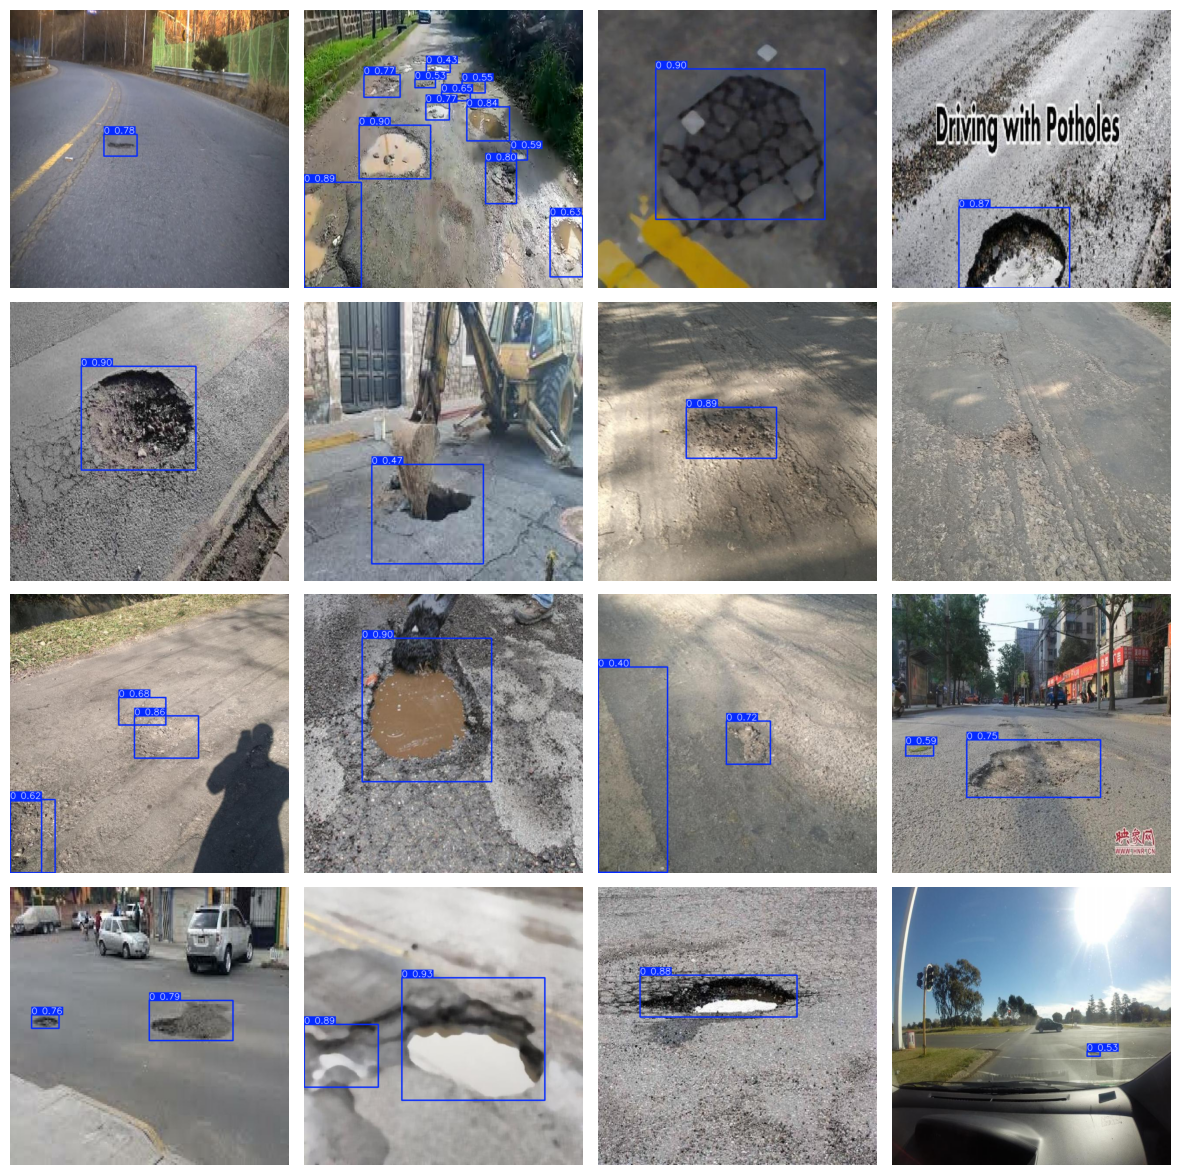

In [ ]:
import random

# Define the directory where the custom images are stored
if chosenModel_specs["dataset"] == "reduced":
    custom_image_dir = os.path.join("reduced_dataset", "test", "images")
else:
    custom_image_dir = os.path.join("dataset", "test", "images")

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

num_objects = [len(r[0].boxes) for r in prediction_stats]  # Use r.boxes for the bounding box data
if 0 not in num_objects:
    raise ValueError("Please run until at least one image is background with no objects!")


### Plot the prediction stats for the selected images

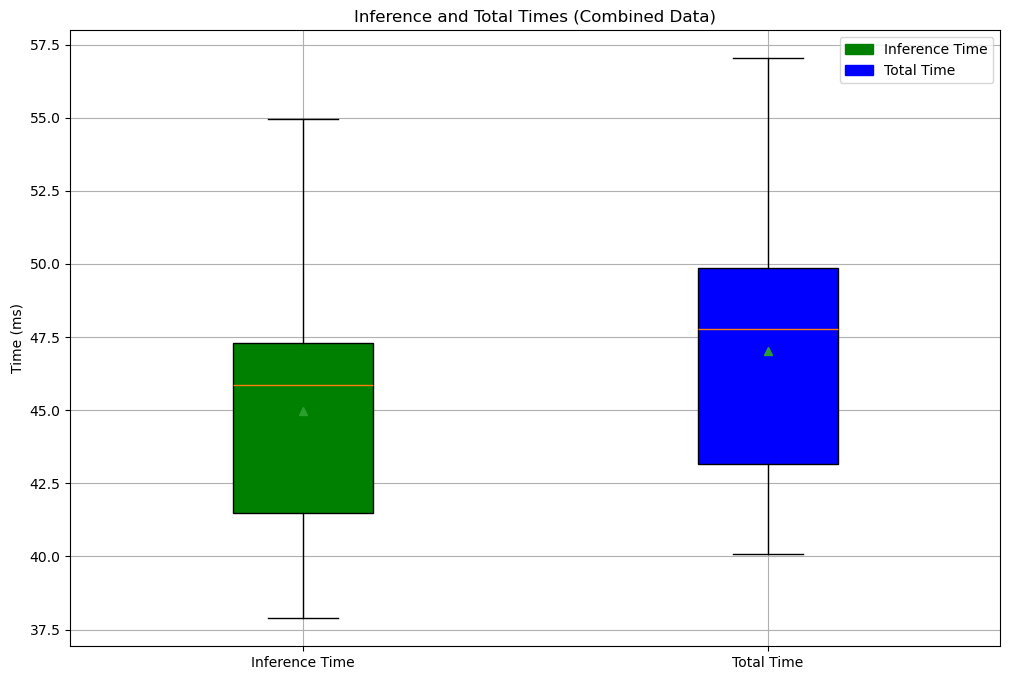

In [9]:
# Extract data
num_objects = [len(r[0].boxes) for r in prediction_stats]  # Use r.boxes for the bounding box data
preprocess_times = [r[0].speed["preprocess"] for r in prediction_stats]
inference_times = [r[0].speed["inference"] for r in prediction_stats]
postprocess_times = [r[0].speed["postprocess"] for r in prediction_stats]
total_times = [p + i + post for p, i, post in zip(preprocess_times, inference_times, postprocess_times)]

# Extract data (no distinction between number of objects)
inference_times_all = [r[0].speed["inference"] for r in prediction_stats][1:]
total_times_all = [p + i + post for p, i, post in zip(preprocess_times, inference_times_all, postprocess_times)][1:]

# Calculate averages and confidence intervals
def compute_stats(data):
    mean = np.mean(data)
    conf_interval = 1.96 * np.std(data) / np.sqrt(len(data))
    return mean, conf_interval

inference_stats_all = compute_stats(inference_times_all)
total_stats_all = compute_stats(total_times_all)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot inference times
ax.boxplot(
    [inference_times_all],
    positions=[0],
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="green"),
    showmeans=True,
)

# Plot total times
ax.boxplot(
    [total_times_all],
    positions=[1],
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="blue"),
    showmeans=True,
)

# Configure plot
ax.set_xticks([0, 1])
ax.set_xticklabels(["Inference Time", "Total Time"])
ax.set_title("Inference and Total Times (Combined Data)")
ax.set_ylabel("Time (ms)")
green_patch = mpatches.Patch(color="green", label="Inference Time")
blue_patch = mpatches.Patch(color="blue", label="Total Time")
ax.legend(handles=[green_patch, blue_patch])
plt.grid(True)
plt.show()


In [10]:
# Print statistics for inference and total times

# Compute stats for 0 objects and multiple objects
def print_stats(label, data):
    mean, conf_interval = compute_stats(data)
    print(f"{label}:")
    print(f"  Mean: {mean:.2f} ms")
    print(f"  95% Confidence Interval: ±{conf_interval:.2f} ms")
    print("-" * 40)

# Print stats
print_stats("Inference Time ", inference_times_all)
print_stats("Total Time for Multiple Objects", total_times_all)

Inference Time :
  Mean: 44.97 ms
  95% Confidence Interval: ±2.26 ms
----------------------------------------
Total Time for Multiple Objects:
  Mean: 47.03 ms
  95% Confidence Interval: ±2.43 ms
----------------------------------------


## Show the YOLO output vs the labeled data

In [11]:
# Function to parse the label file for a given image
def parse_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        # Assuming label file format: <class> <x_center> <y_center> <width> <height>
        parts = line.strip().split()
        class_id = int(parts[0])  # Assuming class_id is the first part
        x_center, y_center, width, height = map(float, parts[1:])
        labels.append((class_id, x_center, y_center, width, height))
    return labels

# Function to perform pothole detections and overlay bounding boxes
def pothole_detect_2(img_path, label_path):
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections (YOLO detections)
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    # Parse the labels from the label file
    labels = parse_labels(label_path)

    # Overlay the label bounding boxes (ground truth)
    for label in labels:
        class_id, x_center, y_center, width, height = label
        # Convert from normalized to pixel coordinates
        h, w, _ = img.shape
        x_center, y_center = int(x_center * w), int(y_center * h)
        width, height = int(width * w), int(height * h)

        # Draw the label bounding box (ground truth)
        cv2.rectangle(detect_img, 
                      (x_center - width // 2, y_center - height // 2), 
                      (x_center + width // 2, y_center + height // 2), 
                      (0, 255, 0), 2)  # Green for ground truth

    return detect_img


0: 640x640 1 0, 71.4ms
Speed: 2.0ms preprocess, 71.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 0s, 78.1ms
Speed: 3.2ms preprocess, 78.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 69.1ms
Speed: 2.4ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 66.7ms
Speed: 4.0ms preprocess, 66.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 44.2ms
Speed: 1.4ms preprocess, 44.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 40.1ms
Speed: 0.9ms preprocess, 40.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 50.3ms
Speed: 1.6ms preprocess, 50.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 40.6ms
Speed: 1.5ms preprocess, 40.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 

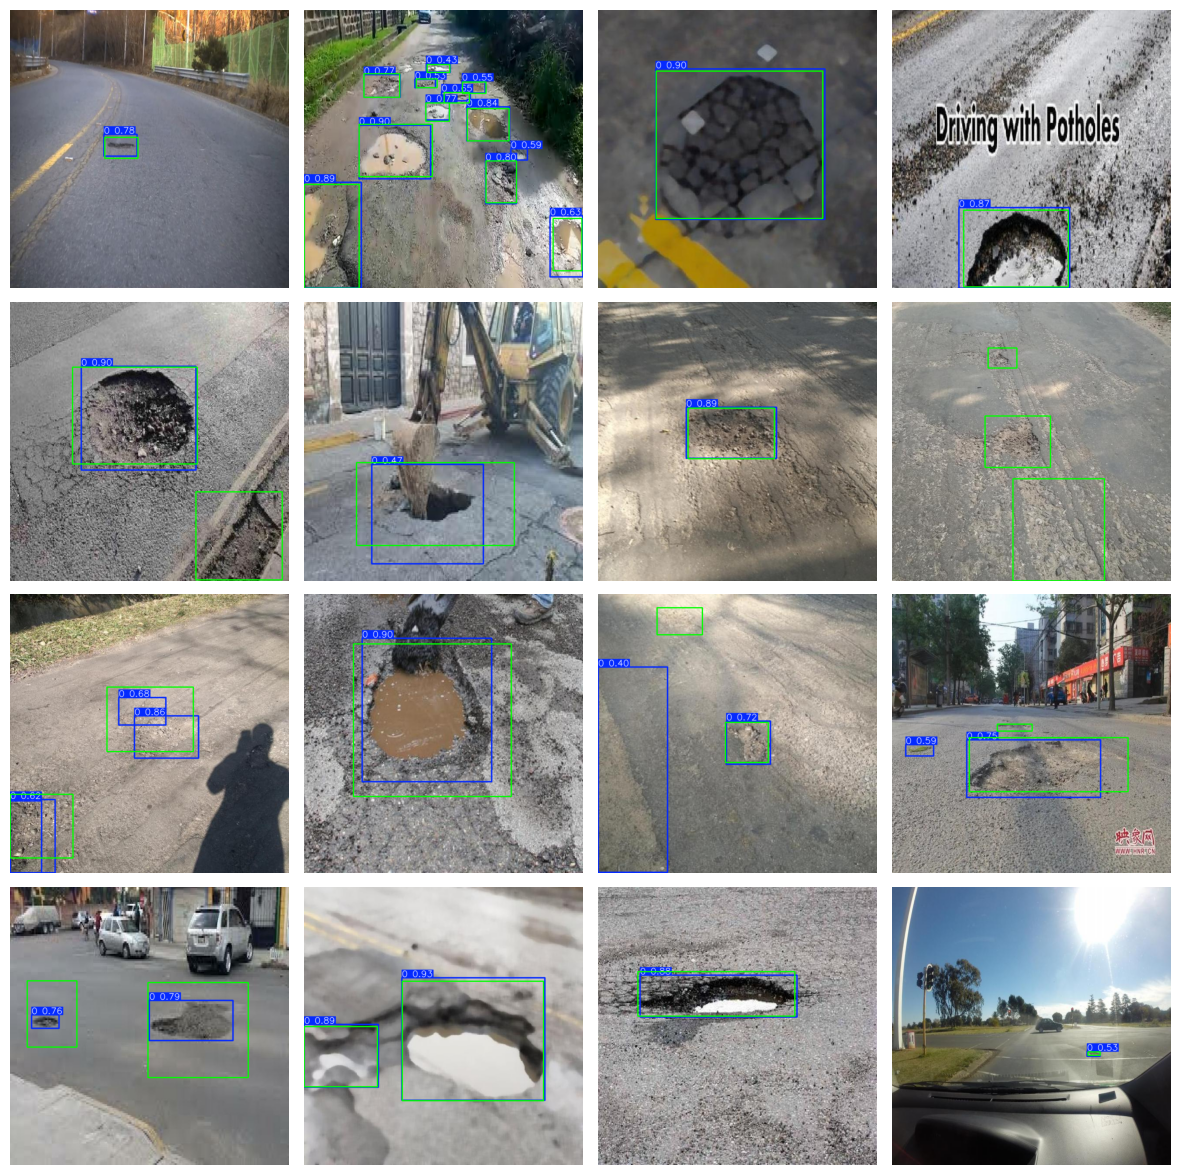

In [20]:
# Define the directory where the custom images are stored
if chosenModel_specs["dataset"] == "reduced":
    custom_image_dir = os.path.join("reduced_dataset", "test", "images")
    label_dir = os.path.join("reduced_dataset", "test", "labels")
else:
    custom_image_dir = os.path.join("dataset", "test", "images")
    label_dir = os.path.join("dataset", "test", "labels")

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select n random images from the list
# selected_images = random.sample(image_files, 16) - Use the ones defined before

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))  # Assuming labels have the same name as images but with .txt extension
    detect_img = pothole_detect_2(img_path, label_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

# Check the model performance with a video

In [17]:
# Load the model
best_model_path = os.path.join(chosenModel_specs["train_path"], "weights", "best.pt")
model = YOLO(best_model_path)  # Load the PyTorch model

# Video input and output paths
#video_name = "pothole_at_70mph_downscaled.mp4"
#video_name = "42_Miles_of_Potholes_downscaled.mp4"
video_name = "dodging_potholes_dashcam_downscaled.mp4"
input_video_path = os.path.join("assets", video_name)
output_video_path = os.path.join("tmp", video_name)

In [19]:

if not os.path.exists("tmp"):
    os.makedirs("tmp")

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Get the video properties (frame width, height, and frames per second)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create a VideoWriter object to save the output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if necessary
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run the model on the current frame
    results = model(frame)  # Perform inference on the frame

    # Parse the results and draw bounding boxes on the frame
    for result in results[0].boxes:  # Access the boxes directly
        x1, y1, x2, y2 = result.xyxy[0]  # Get the bounding box coordinates (x1, y1, x2, y2)
        conf = result.conf[0]  # Confidence score
        cls = result.cls[0]  # Class index

        label = f"{model.names[int(cls)]}: {conf:.2f}"

        # Draw the bounding box and label on the frame
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video processing complete. Output saved to {output_video_path}")

0: 640x640 (no detections), 47.8ms
Speed: 2.2ms preprocess, 47.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 45.1ms
Speed: 0.9ms preprocess, 45.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 47.6ms
Speed: 1.3ms preprocess, 47.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 61.9ms
Speed: 1.4ms preprocess, 61.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 52.2ms
Speed: 1.3ms preprocess, 52.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 45.7ms
Speed: 1.2ms preprocess, 45.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 40.3ms
Speed: 1.0ms preprocess, 40.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 0.3ms postpro